<a href="https://colab.research.google.com/github/shlee0619/Project_Disease/blob/main/0211%EC%BD%94%EB%A1%9C%EB%82%98(%EC%B5%9C%EC%A2%85%EB%B3%B8_%EC%B4%88%EC%95%88)5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
########################################
# 0. 환경 설정 및 라이브러리 설치 (Colab)
########################################
# Google Drive 연동 (Colab 환경인 경우)
from google.colab import drive
drive.mount('/content/gdrive')

# 필요한 라이브러리 설치
!pip install optuna keras-tuner statsmodels prophet tensorflow==2.12.0 tensorflow-addons==0.23.0 keras-tcn xgboost

########################################
# 1. 라이브러리 Import 및 한글 폰트 설정
########################################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# Scikit-learn
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer

# Statsmodels & Prophet
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet

# TensorFlow / Keras & TCN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, clone_model, Model
from tensorflow.keras.layers import (InputLayer, Dense, Dropout, LSTM,
                                     SimpleRNN, GRU, Conv1D, MaxPooling1D, Flatten)
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tcn import TCN

# XGBoost
from xgboost import XGBRegressor

# Optuna
import optuna

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [62]:
# 한글 폰트 설정 (Colab)
!apt-get update -qq
!apt-get install -qq fonts-nanum
import matplotlib.font_manager as fm
fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumGothic.ttf')
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

print("라이브러리 임포트 및 한글 폰트 설정 완료!")

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
라이브러리 임포트 및 한글 폰트 설정 완료!


In [63]:
########################################
# 2. 데이터 로드 및 전처리
########################################
def load_data(data_path):
    """
    여러 인코딩 방식으로 CSV 파일을 불러옵니다.
    """
    try:
        try:
            df_ = pd.read_csv(data_path, encoding='cp949')
        except UnicodeDecodeError:
            try:
                df_ = pd.read_csv(data_path, encoding='latin-1')
            except UnicodeDecodeError:
                df_ = pd.read_csv(data_path, encoding='cp1252')
        print("[INFO] 데이터 불러오기 성공!")
        return df_
    except FileNotFoundError:
        print(f"[ERROR] 파일을 찾을 수 없습니다. 경로: {data_path}")
    except Exception as e:
        print("[ERROR] 예기치 못한 에러 발생:", e)

DATA_PATH = '/content/gdrive/MyDrive/hwda02/data/Processed_COVID_Data_Filled_Plus_Traffic.csv'
df = load_data(DATA_PATH)

[INFO] 데이터 불러오기 성공!


In [64]:

# 원본 변수 목록
original = ['SO2','CO','O3','NO2','PM10','PM25','평균기온(℃)','평균일강수량(mm)','평균풍속(m/s)','평균습도(%rh)','일조합(hr)','일사합(MJ/m2)','Traffic']

# Cases 차분 변수 추가
df['Cases_Diff'] = df['Cases'].diff(1)

# Date 컬럼 처리 및 정렬
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d', errors='coerce')
df = df.sort_values('Date').dropna(subset=['Date']).reset_index(drop=True)

In [65]:

# 간단 EDA 출력
print("\n데이터 예시(상위 5행):")
print(df.head())
print("\n데이터 info:")
print(df.info())
print("\n데이터 통계치:")
print(df.describe())


데이터 예시(상위 5행):
        Date  Cases       SO2        CO        O3       NO2       PM10  \
0 2020-02-01      0  0.003274  0.699089  0.026038  0.022698  63.185218   
1 2020-02-02      0  0.003502  0.748826  0.028493  0.020737  69.092334   
2 2020-02-03      0  0.003140  0.463362  0.029590  0.015894  32.560316   
3 2020-02-04      3  0.003329  0.465114  0.023674  0.019638  29.410079   
4 2020-02-05      3  0.003002  0.374520  0.029291  0.011450  22.960480   

        PM25  평균기온(℃)  평균최고기온(℃)  ...  최다일강수량(mm)  평균풍속(m/s)  최대풍속(m/s)  \
0  47.416719      2.2        7.8  ...         0.2        1.5       12.5   
1  52.897434      2.1        7.8  ...         0.7        1.3        9.5   
2  21.600817      1.3        5.7  ...         0.7        2.3       13.1   
3  18.842018      0.1        6.3  ...         2.0        1.8       13.4   
4  11.594881     -3.6        1.0  ...        26.0        3.0       14.7   

   최대순간풍속(m/s)  평균습도(%rh)  최저습도(%rh)  일조합(hr)  일사합(MJ/m2)  Traffic  Cases_Diff  
0      

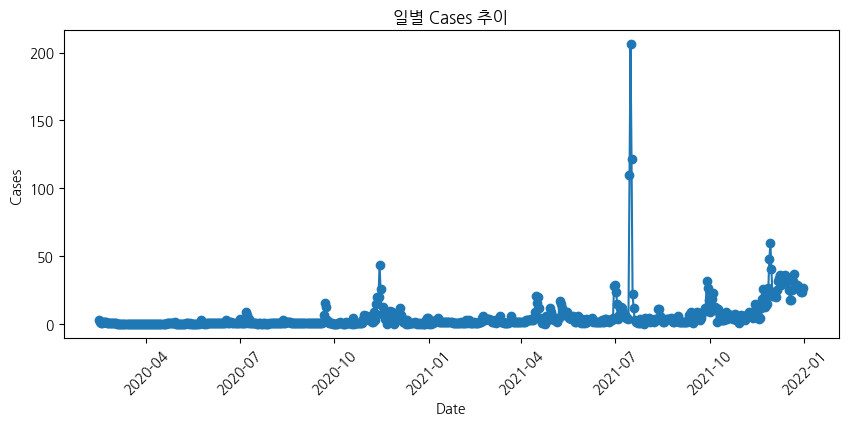

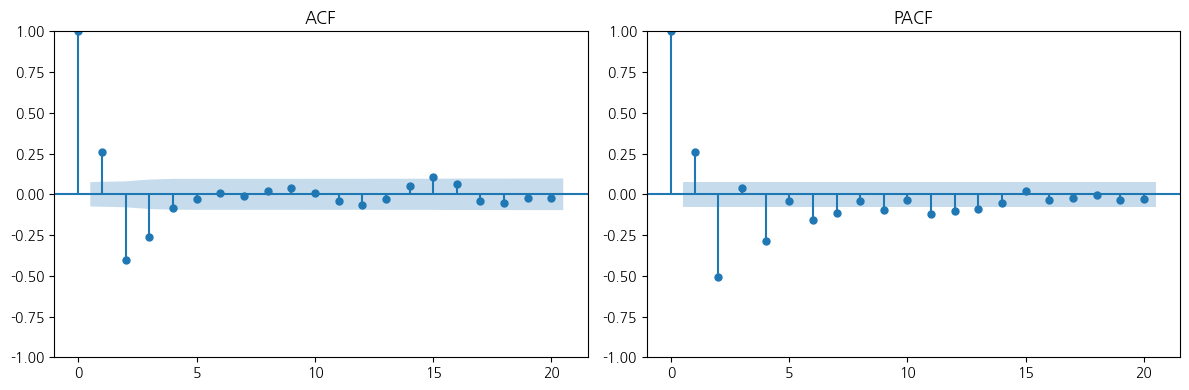

In [79]:
########################################
# 3. 간단 EDA (시각화)
########################################
plt.figure(figsize=(10,4))
plt.plot(df['Date'], df['Cases'], marker='o')
plt.title("일별 Cases 추이")
plt.xlabel("Date")
plt.ylabel("Cases")
plt.xticks(rotation=45)
plt.show()

# ACF 및 PACF 플롯
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plot_acf(df['Cases_Diff'].dropna(), lags=20, ax=plt.gca())
plt.title("ACF")
plt.subplot(1,2,2)
plot_pacf(df['Cases_Diff'].dropna(), lags=20, ax=plt.gca(), method='ywm')
plt.title("PACF")
plt.tight_layout()
plt.show()

In [80]:

########################################
# 4. Lag Feature 생성
########################################
def create_lag_features(dataframe, col_targets, lags):
    """
    col_targets에 대해 지정된 lags 만큼의 새로운 컬럼 생성.
    예: lags=(1,7,14) → 'col_target_lag1', 'col_target_lag7', 'col_target_lag14'
    """
    df_ = dataframe.copy()
    for col_target in col_targets:
        for lag in lags:
            df_[f"{col_target}_lag{lag}"] = df_[col_target].shift(lag)
    df_.dropna(inplace=True)
    return df_

df = create_lag_features(df, ['O3', 'PM25', '평균기온(℃)', '평균습도(%rh)','평균풍속(m/s)','Cases'], [1,2,3,4,5,6,7,8,9,10,11,12,13,14])

In [81]:

# SARIMAX 튜닝 시 사용한 best feature (예시)
# feature_cols = ['SO2','CO','O3','NO2','O3_lag10','평균기온(℃)_lag10', 'PM25_lag13','평균풍속(m/s)_lag13','Traffic', 'Cases_lag1']
feature_cols = ['SO2','CO','O3','NO2','O3_lag10','평균기온(℃)', 'PM25','평균풍속(m/s)','Traffic','Cases_lag1']

In [85]:
########################################
# 5. Train/Validation/Test 분리 및 스케일링
########################################
# 날짜 기준 분할 (Validation < Test)
split_date_test = pd.to_datetime('2021-07-31')
split_date_val = pd.to_datetime('2021-05-31')

train_df = df[df['Date'] <= split_date_val].copy()
val_df = df[(df['Date'] > split_date_val) & (df['Date'] <= split_date_test)].copy()
test_df = df[df['Date'] > split_date_test].copy()
print(f"Train={train_df.shape}, Validation={val_df.shape}, Test={test_df.shape}")

# 타깃 변수 (Cases)
y_train = train_df['Cases']
y_val   = val_df['Cases']
y_test  = test_df['Cases']

# 독립변수 (Feature)
X_train = train_df[feature_cols].dropna()
X_val   = val_df[feature_cols].dropna()
X_test  = test_df[feature_cols].dropna()

# Feature 스케일링 (y는 스케일링하지 않음)
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled   = scaler_X.transform(X_val)
X_test_scaled  = scaler_X.transform(X_test)

y_train_scaled = y_train.values
y_val_scaled   = y_val.values
y_test_scaled  = y_test.values

Train=(458, 108), Validation=(61, 108), Test=(153, 108)


In [86]:

########################################
# 6. 시퀀스 데이터 생성 함수
########################################
def make_sequence_data(X_scaled, y_values, window):
    """
    window 길이만큼 슬라이딩 윈도우로 시퀀스 데이터를 생성합니다.
    X_seq: [샘플 수, window, feature 수]
    y_seq: window 이후의 target 값
    """
    X_seq, y_seq = [], []
    for i in range(len(X_scaled) - window):
        X_seq.append(X_scaled[i:i+window])
        y_seq.append(y_values[i+window])
    return np.array(X_seq), np.array(y_seq)

In [87]:
########################################
# 7. 모델 성능 평가 함수
########################################
def evaluate_performance(y_true, y_pred, model_name="Model"):
    mae_value = mean_absolute_error(y_true, y_pred)
    rmse_value = np.sqrt(mean_squared_error(y_true, y_pred))
    mape_value = mean_absolute_percentage_error(y_true, y_pred)
    print(f"[{model_name}] MAE={mae_value:.3f}, RMSE={rmse_value:.3f}, MAPE={mape_value:.3f}")
    return {'model': model_name, 'MAE': mae_value, 'RMSE': rmse_value, 'MAPE': mape_value}

In [88]:
# 기존 ML 모델 (SARIMAX, XGBoost, SVR, Prophet) 평가 - 이미 정의된 함수 사용
# SARIMAX 예시
sarimax_exog = ['SO2','CO','O3','NO2','O3_lag10','평균기온(℃)_lag10', 'PM25_lag13','평균풍속(m/s)_lag13','Traffic', 'Cases_lag1']
y_train_sar = train_df['Cases']
y_test_sar  = test_df['Cases']
X_train_sar = train_df[sarimax_exog]
X_test_sar  = test_df[sarimax_exog]
sar_model = sm.tsa.statespace.SARIMAX(
    endog=y_train_sar,
    exog=X_train_sar,
    order=(1,0,1),
    seasonal_order=(0,0,1,7),
    enforce_stationarity=False,
    enforce_invertibility=False
)
sar_result = sar_model.fit(disp=False)
print(sar_result.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                             Cases   No. Observations:                  458
Model:             SARIMAX(1, 0, 1)x(0, 0, 1, 7)   Log Likelihood               -1513.477
Date:                           Tue, 11 Feb 2025   AIC                           3054.953
Time:                                   08:34:00   BIC                           3112.452
Sample:                                        0   HQIC                          3077.618
                                           - 458                                         
Covariance Type:                             opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
SO2               106.2244   8.26e-05   1.29e+06      0.000     106.224     106.225
CO                 -2.2109  

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [89]:
n_test = len(y_test_sar)
pred_sar = sar_result.predict(
    start=len(y_train_sar),
    end=len(y_train_sar)+n_test-1,
    exog=X_test_sar
)

# 평가 함수 사용: MAE, RMSE, MAPE 계산
sar_mae = mean_absolute_error(y_test_sar, pred_sar)
sar_rmse= np.sqrt(mean_squared_error(y_test_sar, pred_sar))
print("[SARIMAX] MAE=%.3f, RMSE=%.3f" % (sar_mae, sar_rmse))

[SARIMAX] MAE=4193261881422228227267261419046349179135317415531121175469617917722624.000, RMSE=36253226411725585502171568745066358574740638012223578266505299422609408.000


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


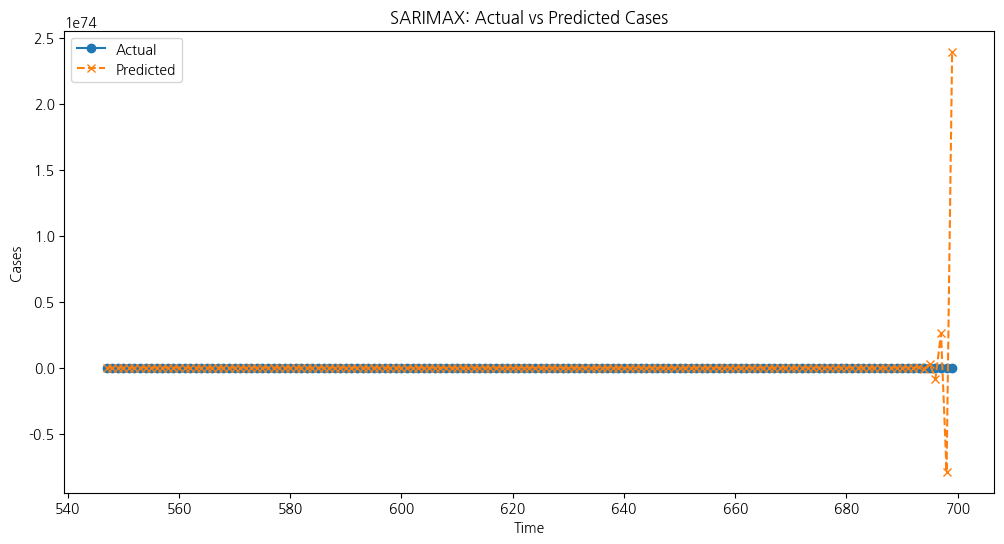

In [78]:
########################################
# SARIMAX 예측 결과 시각화 및 잔차 분석
########################################
import matplotlib.pyplot as plt

# 실제값과 예측값 시각화 (x축은 인덱스 또는 날짜 사용)
plt.figure(figsize=(12,6))
# 만약 y_test_sar의 인덱스가 날짜라면 그대로 사용 가능
plt.plot(y_test_sar.index, y_test_sar, label='Actual', marker='o', linestyle='-')
plt.plot(y_test_sar.index, pred_sar, label='Predicted', marker='x', linestyle='--')
plt.xlabel("Time")
plt.ylabel("Cases")
plt.title("SARIMAX: Actual vs Predicted Cases")
plt.legend()
plt.show()

In [92]:
sarimax_exog = ['SO2','CO','O3','NO2','Traffic', 'Cases_lag1']

# 인덱스 재설정: 날짜 인덱스 대신 RangeIndex 사용
y_train_sar = train_df['Cases'].reset_index(drop=True)
y_test_sar  = test_df['Cases'].reset_index(drop=True)
X_train_sar = train_df[sarimax_exog].reset_index(drop=True)
X_test_sar  = test_df[sarimax_exog].reset_index(drop=True)

sar_model = sm.tsa.statespace.SARIMAX(
    endog=y_train_sar,
    exog=X_train_sar,
    order=(1,0,1),
    seasonal_order=(0,0,1,7),
    enforce_stationarity=False,
    enforce_invertibility=False
)
sar_result = sar_model.fit(disp=False)
print(sar_result.summary())

n_test = len(y_test_sar)
pred_sar = sar_result.predict(
    start=len(y_train_sar),
    end=len(y_train_sar)+n_test-1,
    exog=X_test_sar
)

# 평가 함수 사용: MAE, RMSE, MAPE 계산
sar_mae = mean_absolute_error(y_test_sar, pred_sar)
sar_rmse= np.sqrt(mean_squared_error(y_test_sar, pred_sar))
sar_mape = mean_absolute_percentage_error(y_test_sar, pred_sar)
print(f"[SARIMAX] MAE={sar_mae:.3f}, RMSE={sar_rmse:.3f}, MAPE={sar_mape:.3f}")

                                     SARIMAX Results                                     
Dep. Variable:                             Cases   No. Observations:                  458
Model:             SARIMAX(1, 0, 1)x(0, 0, 1, 7)   Log Likelihood               -1591.599
Date:                           Tue, 11 Feb 2025   AIC                           3203.199
Time:                                   08:37:34   BIC                           3244.269
Sample:                                        0   HQIC                          3219.387
                                           - 458                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
SO2          285.1878   3.04e-05   9.37e+06      0.000     285.188     285.188
CO            -3.0026      0.006   -503.524

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [96]:
########################################
# 5. Train/Test 분리 (날짜 기준)
########################################
#  예시로 2021-07-31을 기준으로 분할
########################################
split_date = pd.to_datetime('2021-07-31')
train_df = df[df['Date'] <= split_date].copy()
test_df = df[df['Date'] > split_date].copy()

print(f"Train={train_df.shape}, Test={test_df.shape}")

X_train = train_df[feature_cols]
y_train = train_df['Cases']
X_test  = test_df[feature_cols]
y_test  = test_df['Cases']

# 결측 제거(Shift로 생긴 결측)
X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]

X_test = X_test.dropna()
y_test = y_test.loc[X_test.index]

print("최종 학습세트 크기:", X_train.shape, "테스트세트 크기:", X_test.shape)

Train=(519, 108), Test=(153, 108)
최종 학습세트 크기: (519, 10) 테스트세트 크기: (153, 10)


In [97]:
########################################
# 6. 데이터 스케일링 (필요시)
########################################
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# y도 스케일링 (딥러닝 모델에서 사용)
scaler_y = MinMaxScaler()
y_train_scaled = y_train
y_test_scaled = y_test

In [98]:
########################################
# 8-1. SARIMAX (ARIMAX) 예시
########################################
def train_sarimax(train_data, test_data, exog_cols, order=(1,0,1), seasonal_order=(0,0,1,7)):
    """
    SARIMAX(ARIMAX) 모델을 학습하고 예측값을 반환.
    order, seasonal_order는 필요에 따라 조정.
    """
    # train
    y_train_sar = train_data['Cases']
    X_train_sar = train_data[exog_cols]

    # test
    y_test_sar  = test_data['Cases']
    X_test_sar  = test_data[exog_cols]

    model = sm.tsa.statespace.SARIMAX(
        endog=y_train_sar,
        exog=X_train_sar,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    result = model.fit(disp=False)
    print("SARIMAX 학습 완료! summary:\n", result.summary())

    # 예측
    n_test = len(y_test_sar)
    forecast = result.predict(
        start=len(y_train_sar),
        end=len(y_train_sar)+n_test-1,
        exog=X_test_sar
    )
    return forecast


sarimax_pred = train_sarimax(train_df, test_df, exog_cols=feature_cols)
sarimax_result = evaluate_performance(y_test, sarimax_pred, model_name="SARIMAX")

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX 학습 완료! summary:
                                      SARIMAX Results                                     
Dep. Variable:                             Cases   No. Observations:                  519
Model:             SARIMAX(1, 0, 1)x(0, 0, 1, 7)   Log Likelihood               -1707.084
Date:                           Tue, 11 Feb 2025   AIC                           3442.167
Time:                                   08:40:27   BIC                           3501.449
Sample:                                        0   HQIC                          3465.410
                                           - 519                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
SO2         1216.5373    5.6e-06   2.17e+08      0.000    1216.537    1216.537
CO            -9.7

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
########################################
# 8. 모델 빌드 함수 (다층 구성 지원)
########################################
def build_lstm_model(input_shape, lstm_units, dropout_rate, learning_rate, num_layers):
    model = Sequential()
    model.add(LSTM(lstm_units, activation='tanh', return_sequences=(num_layers > 1), input_shape=input_shape))
    for i in range(1, num_layers):
        return_seq = (i < num_layers - 1)
        model.add(LSTM(lstm_units, activation='tanh', return_sequences=return_seq))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.MeanAbsolutePercentageError())
    return model

def build_gru_model(input_shape, gru_units, dropout_rate, learning_rate, num_layers):
    model = Sequential()
    model.add(GRU(gru_units, activation='tanh', return_sequences=(num_layers > 1), input_shape=input_shape))
    for i in range(1, num_layers):
        return_seq = (i < num_layers - 1)
        model.add(GRU(gru_units, activation='tanh', return_sequences=return_seq))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.MeanAbsolutePercentageError())
    return model

def build_rnn_model(input_shape, rnn_units, dropout_rate, learning_rate, num_layers):
    model = Sequential()
    model.add(SimpleRNN(rnn_units, activation='tanh', return_sequences=(num_layers > 1), input_shape=input_shape))
    for i in range(1, num_layers):
        return_seq = (i < num_layers - 1)
        model.add(SimpleRNN(rnn_units, activation='tanh', return_sequences=return_seq))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.MeanAbsolutePercentageError())
    return model

def build_cnn_model(input_shape, conv_filters, kernel_size, dropout_rate, optimizer_choice, learning_rate, num_layers=1):
    model = Sequential()
    # 첫 번째 Conv1D 레이어
    model.add(Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu',
                     input_shape=input_shape, padding='same'))
    # 추가 Conv1D 및 Dropout 레이어
    for i in range(1, num_layers):
        model.add(Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu', padding='same'))
        model.add(Dropout(dropout_rate))
    # 시간 축을 1차원으로 flatten
    model.add(Flatten())
    # 최종 출력층
    model.add(Dense(1))

    # 옵티마이저 설정
    if optimizer_choice == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    elif optimizer_choice == 'sgd':
        opt = SGD(learning_rate=learning_rate)
    else:
        opt = Adam(learning_rate=learning_rate)

    model.compile(optimizer=opt, loss=tf.keras.losses.MeanAbsolutePercentageError())
    return model


In [ ]:

########################################
# 9. Optuna Objective Functions (Time Step 및 num_layers 튜닝)
########################################

In [ ]:
def objective_lstm_for_timestep(trial, X_train_seq, y_train_seq, X_val_seq, y_val_seq, timesteps):
    lstm_units = trial.suggest_int("lstm_units", 32, 256, step=32)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.1)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    num_layers = trial.suggest_int("num_layers", 1, 3)
    epochs = 10  # 빠른 튜닝을 위한 epoch 수 축소

    model = build_lstm_model(
        input_shape=(timesteps, X_train_seq.shape[2]),
        lstm_units=lstm_units,
        dropout_rate=dropout_rate,
        learning_rate=learning_rate,
        num_layers=num_layers
    )
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        callbacks=[early_stop]
    )
    return min(history.history['val_loss'])

In [ ]:
def objective_gru_for_timestep(trial, X_train_seq, y_train_seq, X_val_seq, y_val_seq, timesteps):
    gru_units = trial.suggest_int("gru_units", 32, 256, step=32)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.1)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    num_layers = trial.suggest_int("num_layers", 1, 3)
    epochs = 10

    model = build_gru_model(
        input_shape=(timesteps, X_train_seq.shape[2]),
        gru_units=gru_units,
        dropout_rate=dropout_rate,
        learning_rate=learning_rate,
        num_layers=num_layers
    )
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        callbacks=[early_stop]
    )
    return min(history.history['val_loss'])

In [ ]:
def objective_rnn_for_timestep(trial, X_train_seq, y_train_seq, X_val_seq, y_val_seq, timesteps):
    rnn_units = trial.suggest_int("rnn_units", 32, 256, step=32)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.1)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    num_layers = trial.suggest_int("num_layers", 1, 3)
    epochs = 10

    model = build_rnn_model(
        input_shape=(timesteps, X_train_seq.shape[2]),
        rnn_units=rnn_units,
        dropout_rate=dropout_rate,
        learning_rate=learning_rate,
        num_layers=num_layers
    )
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        callbacks=[early_stop]
    )
    return min(history.history['val_loss'])

In [ ]:
def objective_cnn_for_timestep(trial, X_train_seq, y_train_seq, X_val_seq, y_val_seq, timesteps):
    conv_filters = trial.suggest_int('conv_filters', 16, 64, step=16)
    kernel_size = trial.suggest_int('kernel_size', 2, 5)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5, step=0.1)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    optimizer_choice = trial.suggest_categorical('optimizer_choice', ['adam', 'rmsprop', 'sgd'])
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    epochs = 5

    model = build_cnn_model(
        input_shape=(timesteps, X_train_seq.shape[2]),
        conv_filters=conv_filters,
        kernel_size=kernel_size,
        dropout_rate=dropout_rate,
        optimizer_choice=optimizer_choice,
        learning_rate=learning_rate,
        num_layers=num_layers
    )

    cv_mapes = []
    from sklearn.model_selection import TimeSeriesSplit
    tscv_ = TimeSeriesSplit(n_splits=3)
    for train_idx, val_idx in tscv_.split(X_train_seq):
        X_train_cv, X_val_cv = X_train_seq[train_idx], X_train_seq[val_idx]
        y_train_cv, y_val_cv = y_train_seq[train_idx], y_train_seq[val_idx]
        model_cv = clone_model(model)
        model_cv.set_weights(model.get_weights())
        model_cv.compile(optimizer=tf.keras.optimizers.get(optimizer_choice),
                           loss=tf.keras.losses.MeanAbsolutePercentageError(),
                           metrics=['mse', tf.keras.metrics.MeanAbsolutePercentageError()])
        hist = model_cv.fit(
            X_train_cv, y_train_cv,
            validation_data=(X_val_cv, y_val_cv),
            epochs=epochs,
            batch_size=batch_size,
            verbose=0,
            shuffle=False
        )
        cv_mapes.append(hist.history['val_mean_absolute_percentage_error'][-1])
    return np.mean(cv_mapes)

In [ ]:
########################################
# 10. Time Step 및 Hyperparameter 튜닝 실행 (Validation Set 사용)
########################################
timesteps_candidates = range(5, 14)
dl_results_timestep_tuning = []

for timesteps in timesteps_candidates:
    print(f"\n===== Time Steps: {timesteps} =====")

    # 데이터 준비: Feature/Target 분리 및 스케일링 (Validation set 포함)
    X_train_sub = train_df[feature_cols].dropna()
    X_val_sub   = val_df[feature_cols].dropna()
    X_test_sub  = test_df[feature_cols].dropna()

    X_train_scaled_sub = scaler_X.fit_transform(X_train_sub)
    X_val_scaled_sub   = scaler_X.transform(X_val_sub)
    X_test_scaled_sub  = scaler_X.transform(X_test_sub)

    # y index 정렬
    y_train_aligned = y_train.loc[X_train_sub.index]
    y_val_aligned   = y_val.loc[X_val_sub.index]
    y_test_aligned  = y_test.loc[X_test_sub.index]

    # 시퀀스 데이터 생성
    X_train_seq, y_train_seq = make_sequence_data(X_train_scaled_sub, y_train_aligned.values, window=timesteps)
    X_val_seq, y_val_seq     = make_sequence_data(X_val_scaled_sub, y_val_aligned.values, window=timesteps)
    X_test_seq, y_test_seq   = make_sequence_data(X_test_scaled_sub, y_test_scaled, window=timesteps)

    ########################################
    # LSTM 튜닝 및 평가
    ########################################
    study_lstm = optuna.create_study(direction='minimize')
    objective_lstm = lambda trial: objective_lstm_for_timestep(trial, X_train_seq, y_train_seq, X_val_seq, y_val_seq, timesteps)
    study_lstm.optimize(objective_lstm, n_trials=10)
    best_params_lstm = study_lstm.best_trial.params
    lstm_model = build_lstm_model(
        input_shape=(timesteps, X_train_seq.shape[2]),
        lstm_units=best_params_lstm['lstm_units'],
        dropout_rate=best_params_lstm['dropout_rate'],
        learning_rate=best_params_lstm['learning_rate'],
        num_layers=best_params_lstm['num_layers']
    )
    epochs_best = 20
    lstm_model.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq),
                   epochs=epochs_best, batch_size=best_params_lstm['batch_size'], verbose=0)
    lstm_pred = lstm_model.predict(X_test_seq).flatten()
    lstm_result = evaluate_performance(y_test_seq, lstm_pred, model_name="LSTM")
    dl_results_timestep_tuning.append({'Time Steps': timesteps, 'Model': 'LSTM', 'Best Params': best_params_lstm, **lstm_result})

    ########################################
    # GRU 튜닝 및 평가
    ########################################
    study_gru = optuna.create_study(direction='minimize')
    objective_gru = lambda trial: objective_gru_for_timestep(trial, X_train_seq, y_train_seq, X_val_seq, y_val_seq, timesteps)
    study_gru.optimize(objective_gru, n_trials=10)
    best_params_gru = study_gru.best_trial.params
    gru_model = build_gru_model(
        input_shape=(timesteps, X_train_seq.shape[2]),
        gru_units=best_params_gru['gru_units'],
        dropout_rate=best_params_gru['dropout_rate'],
        learning_rate=best_params_gru['learning_rate'],
        num_layers=best_params_gru['num_layers']
    )
    gru_model.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq),
                  epochs=epochs_best, batch_size=best_params_gru['batch_size'], verbose=0)
    gru_pred = gru_model.predict(X_test_seq).flatten()
    gru_result = evaluate_performance(y_test_seq, gru_pred, model_name="GRU")
    dl_results_timestep_tuning.append({'Time Steps': timesteps, 'Model': 'GRU', 'Best Params': best_params_gru, **gru_result})

    ########################################
    # RNN 튜닝 및 평가
    ########################################
    study_rnn = optuna.create_study(direction='minimize')
    objective_rnn = lambda trial: objective_rnn_for_timestep(trial, X_train_seq, y_train_seq, X_val_seq, y_val_seq, timesteps)
    study_rnn.optimize(objective_rnn, n_trials=10)
    best_params_rnn = study_rnn.best_trial.params
    rnn_model = build_rnn_model(
        input_shape=(timesteps, X_train_seq.shape[2]),
        rnn_units=best_params_rnn['rnn_units'],
        dropout_rate=best_params_rnn['dropout_rate'],
        learning_rate=best_params_rnn['learning_rate'],
        num_layers=best_params_rnn['num_layers']
    )
    rnn_model.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq),
                  epochs=epochs_best, batch_size=best_params_rnn['batch_size'], verbose=0)
    rnn_pred = rnn_model.predict(X_test_seq).flatten()
    rnn_result = evaluate_performance(y_test_seq, rnn_pred, model_name="RNN")
    dl_results_timestep_tuning.append({'Time Steps': timesteps, 'Model': 'RNN', 'Best Params': best_params_rnn, **rnn_result})

    ########################################
    # CNN 튜닝 및 평가
    ########################################
    study_cnn = optuna.create_study(direction='minimize')
    objective_cnn = lambda trial: objective_cnn_for_timestep(trial, X_train_seq, y_train_seq, X_val_seq, y_val_seq, timesteps)
    study_cnn.optimize(objective_cnn, n_trials=10)
    best_params_cnn = study_cnn.best_trial.params
    cnn_model = build_cnn_model(
        input_shape=(timesteps, X_train_seq.shape[2]),
        conv_filters=best_params_cnn['conv_filters'],
        kernel_size=best_params_cnn['kernel_size'],
        dropout_rate=best_params_cnn['dropout_rate'],
        optimizer_choice=best_params_cnn['optimizer_choice'],
        learning_rate=best_params_cnn['learning_rate'],
        num_layers=best_params_cnn['num_layers']
    )
    cnn_model.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq),
                  epochs=epochs_best, batch_size=best_params_cnn['batch_size'], verbose=0)
    cnn_pred = cnn_model.predict(X_test_seq).flatten()
    cnn_result = evaluate_performance(y_test_seq, cnn_pred, model_name="CNN")

    dl_results_timestep_tuning.append({'Time Steps': timesteps, 'Model': 'CNN', 'Best Params': best_params_cnn, **cnn_result})

[I 2025-02-11 08:18:58,454] A new study created in memory with name: no-name-713e02de-1348-466a-915a-aae982e165f2



===== Time Steps: 5 =====


<ipython-input-29-e563e20cbaad>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-11 08:19:03,700] Trial 0 finished with value: 4232.6572265625 and parameters: {'lstm_units': 96, 'dropout_rate': 0.4, 'learning_rate': 0.0010453947190892775, 'batch_size': 32, 'num_layers': 1}. Best is trial 0 with value: 4232.6572265625.
[I 2025-02-11 08:19:11,644] Trial 1 finished with value: 14254.94921875 and parameters: {'lstm_units': 224, 'dropout_rate': 0.1, 'learning_rate': 0.004484969854174738, 'batch_size': 16, 'num_layers': 1}. Best is trial 0 with value: 4232.6572265625.
[I 2025-02-11 08:19:26,899] Trial 2 finished with value: 130246.234375 and parameters: {'lstm_units': 224, 'dropout_rate': 0.2, 'learning_rate': 0.00021936633379411277, 'batch_size': 16, 'n

5/5 [==============================] - 2s 14ms/step


[I 2025-02-11 08:21:42,699] A new study created in memory with name: no-name-e1946d31-773b-4308-8ff2-9848f6c36982


[LSTM] MAE=12.480, RMSE=16.969, MAPE=1.000


<ipython-input-30-d3153d3c36d9>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[W 2025-02-11 08:21:47,311] Trial 0 failed with parameters: {'gru_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.00019650372864582786, 'batch_size': 16, 'num_layers': 1} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "<ipython-input-53-d08582ce6705>", line 54, in <lambda>
    objective_gru = lambda trial: objective_gru_for_timestep(trial, X_train_seq, y_train_seq, X_val_seq, y_val_seq, timesteps)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

KeyboardInterrupt: 

In [ ]:
########################################
# 11. 최종 결과 비교 (딥러닝 모델 및 기존 ML 모델)
########################################
dl_results_df = pd.DataFrame(dl_results_timestep_tuning)
print("\n=== 딥러닝 모델 Time Step 및 Hyperparameter Tuning 결과 ===")
display(dl_results_df)

# 각 모델별 Best Time Steps (MAPE 기준) 출력
best_lstm_row = dl_results_df[dl_results_df['Model'] == 'LSTM'].sort_values(by='MAPE').iloc[0]
best_gru_row  = dl_results_df[dl_results_df['Model'] == 'GRU'].sort_values(by='MAPE').iloc[0]
best_rnn_row  = dl_results_df[dl_results_df['Model'] == 'RNN'].sort_values(by='MAPE').iloc[0]
best_cnn_row  = dl_results_df[dl_results_df['Model'] == 'CNN'].sort_values(by='MAPE').iloc[0]

print("\n=== 각 모델별 Best Time Steps (MAPE 기준) ===")
print(f"[LSTM] Best Time Steps: {best_lstm_row['Time Steps']}, MAPE: {best_lstm_row['MAPE']:.3f}, Hyperparams: {best_lstm_row['Best Params']}")
print(f"[GRU]  Best Time Steps: {best_gru_row['Time Steps']}, MAPE: {best_gru_row['MAPE']:.3f}, Hyperparams: {best_gru_row['Best Params']}")
print(f"[RNN]  Best Time Steps: {best_rnn_row['Time Steps']}, MAPE: {best_rnn_row['MAPE']:.3f}, Hyperparams: {best_rnn_row['Best Params']}")
print(f"[CNN]  Best Time Steps: {best_cnn_row['Time Steps']}, MAPE: {best_cnn_row['MAPE']:.3f}, Hyperparams: {best_cnn_row['Best Params']}")

In [ ]:
n_test = len(y_test_sar)
pred_sar = sar_result.predict(
    start=len(y_train_sar),
    end=len(y_train_sar)+n_test-1,
    exog=X_test_sar
)
sar_mae = mean_absolute_error(y_test_sar, pred_sar)
sar_rmse= np.sqrt(mean_squared_error(y_test_sar, pred_sar))
print("[SARIMAX] MAE=%.3f, RMSE=%.3f" % (sar_mae, sar_rmse))


[SARIMAX] MAE=9083948089579592392389958535648963030156452618529509309803797693022667910848480018432.000, RMSE=84701568628459314055589178682321527417849152011178475927401641973842138448549992464384.000


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [60]:
import optuna
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import numpy as np
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# X_train_scaled, y_train_scaled는 이미 스케일링된 train 데이터입니다.
# 예를 들어, 이전 코드에서 X_train_scaled = scaler_X.fit_transform(X_train) 등으로 생성

########################################
# 1. SVR 하이퍼파라미터 최적화
########################################
def objective_svr(trial):
    # 주요 파라미터: kernel, gamma, C, epsilon
    kernel = trial.suggest_categorical('kernel', ['rbf', 'linear', 'poly'])
    if kernel in ['rbf', 'poly']:
        gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)
    else:
        gamma = 'scale'
    C = trial.suggest_loguniform('C', 0.1, 100.0)
    epsilon = trial.suggest_loguniform('epsilon', 0.01, 1.0)

    model = SVR(kernel=kernel, gamma=gamma, C=C, epsilon=epsilon)
    tscv = TimeSeriesSplit(n_splits=3)
    scores = cross_val_score(model, X_train_scaled, y_train_scaled, cv=tscv,
                             scoring='neg_mean_absolute_percentage_error')
    return -np.mean(scores)

study_svr = optuna.create_study(direction='minimize')
study_svr.optimize(objective_svr, n_trials=30)
best_params_svr = study_svr.best_trial.params
print("Best SVR parameters:", best_params_svr)

########################################
# 2. Random Forest (RF) 하이퍼파라미터 최적화
########################################
def objective_rf(trial):
    # 주요 파라미터: n_estimators, criterion, min_samples_split, min_samples_leaf, max_features
    n_estimators = trial.suggest_int('n_estimators', 50, 300, step=50)
    criterion = trial.suggest_categorical('criterion', ['squared_error', 'absolute_error'])
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        criterion=criterion,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )
    tscv = TimeSeriesSplit(n_splits=3)
    scores = cross_val_score(model, X_train_scaled, y_train_scaled, cv=tscv,
                             scoring='neg_mean_absolute_percentage_error')
    return -np.mean(scores)

study_rf = optuna.create_study(direction='minimize')
study_rf.optimize(objective_rf, n_trials=30)
best_params_rf = study_rf.best_trial.params
print("Best RF parameters:", best_params_rf)

########################################
# 3. XGBoost 하이퍼파라미터 최적화
########################################
# def objective_xgb(trial):
#     # 주요 파라미터: booster, eta (learning_rate), max_depth, min_child_weight, sampling_method, tree_method, base_score
#     booster = trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart'])
#     eta = trial.suggest_float('eta', 0.01, 0.3, step=0.01)
#     max_depth = trial.suggest_int('max_depth', 3, 10)
#     min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
#     sampling_method = trial.suggest_categorical('sampling_method', ['uniform', 'gradient_based'])
#     tree_method = trial.suggest_categorical('tree_method', ['auto', 'exact', 'approx', 'hist'])
#     base_score = trial.suggest_float('base_score', 0.1, 0.5)

#     model = XGBRegressor(
#         booster=booster,
#         learning_rate=eta,
#         max_depth=max_depth,
#         min_child_weight=min_child_weight,
#         sampling_method=sampling_method,
#         tree_method=tree_method,
#         base_score=base_score,
#         n_estimators=200,
#         random_state=42
#     )
#     tscv = TimeSeriesSplit(n_splits=3)
#     scores = cross_val_score(model, X_train_scaled, y_train_scaled, cv=tscv,
#                              scoring='neg_mean_absolute_percentage_error')
#     return -np.mean(scores)

# study_xgb = optuna.create_study(direction='minimize')
# study_xgb.optimize(objective_xgb, n_trials=30)
# best_params_xgb = study_xgb.best_trial.params
# print("Best XGBoost parameters:", best_params_xgb)
def objective_xgb(trial):
    # Optuna로 튜닝할 주요 파라미터들
    booster = trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart'])
    eta = trial.suggest_float('eta', 0.01, 0.3, step=0.01)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    sampling_method = trial.suggest_categorical('sampling_method', ['uniform', 'gradient_based'])
    tree_method = trial.suggest_categorical('tree_method', ['auto', 'exact', 'approx', 'hist'])
    base_score = trial.suggest_float('base_score', 0.1, 0.5)

    # XGBoost 모델 생성
    model = XGBRegressor(
        booster=booster,
        learning_rate=eta,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        sampling_method=sampling_method,
        tree_method=tree_method,
        base_score=base_score,
        n_estimators=200,
        random_state=42
    )

    # TimeSeriesSplit으로 교차 검증 직접 구현
    tscv = TimeSeriesSplit(n_splits=3)
    mape_scores = []

    for train_index, val_index in tscv.split(X_train_scaled):
        X_cv_train, X_cv_val = X_train_scaled[train_index], X_train_scaled[val_index]
        y_cv_train, y_cv_val = y_train_scaled[train_index], y_train_scaled[val_index]

        # 모델 훈련
        model.fit(X_cv_train, y_cv_train)

        # 예측
        y_pred = model.predict(X_cv_val)

        # MAPE 계산
        mape = mean_absolute_percentage_error(y_cv_val, y_pred)
        mape_scores.append(mape)

    # 평균 MAPE가 작을수록 좋은 모델이므로, 이를 최소화
    return np.mean(mape_scores)


study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(objective_xgb, n_trials=30)

best_params_xgb = study_xgb.best_trial.params
print("Best XGBoost parameters:", best_params_xgb)

########################################
# 4. 최적의 하이퍼파라미터로 최종 모델 학습 및 평가
########################################

# SVR 최적의 파라미터로 모델 학습 및 평가
svr_model_opt = SVR(kernel=best_params_svr['kernel'],
                    gamma=best_params_svr['gamma'] if best_params_svr['kernel'] in ['rbf','poly'] else 'scale',
                    C=best_params_svr['C'],
                    epsilon=best_params_svr['epsilon'])
svr_model_opt.fit(X_train_scaled, y_train_scaled)
svr_pred_opt = svr_model_opt.predict(X_test_scaled)
svr_result_opt = evaluate_performance(y_test, svr_pred_opt, model_name="SVM(SVR)_Optuna")

# RF 최적의 파라미터로 모델 학습 및 평가
rf_model_opt = RandomForestRegressor(
    n_estimators=best_params_rf['n_estimators'],
    criterion=best_params_rf['criterion'],
    min_samples_split=best_params_rf['min_samples_split'],
    min_samples_leaf=best_params_rf['min_samples_leaf'],
    max_features=best_params_rf['max_features'],
    random_state=42
)
rf_model_opt.fit(X_train_scaled, y_train_scaled)
rf_pred_opt = rf_model_opt.predict(X_test_scaled)
rf_result_opt = evaluate_performance(y_test, rf_pred_opt, model_name="RF_Optuna")

# XGBoost 최적의 파라미터로 모델 학습 및 평가
xgb_model_opt = XGBRegressor(
    booster=best_params_xgb['booster'],
    learning_rate=best_params_xgb['eta'],
    max_depth=best_params_xgb['max_depth'],
    min_child_weight=best_params_xgb['min_child_weight'],
    sampling_method=best_params_xgb['sampling_method'],
    tree_method=best_params_xgb['tree_method'],
    base_score=best_params_xgb['base_score'],
    n_estimators=200,
    random_state=42
)
xgb_model_opt.fit(X_train_scaled, y_train_scaled)
xgb_pred_opt = xgb_model_opt.predict(X_test_scaled)
xgb_result_opt = evaluate_performance(y_test, xgb_pred_opt, model_name="XGBoost_Optuna")


[I 2025-02-11 08:27:52,506] A new study created in memory with name: no-name-a69223a3-6771-445a-bf97-e5d739dbc439
<ipython-input-60-4f4c9cb90070>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 0.1, 100.0)
<ipython-input-60-4f4c9cb90070>:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  epsilon = trial.suggest_loguniform('epsilon', 0.01, 1.0)
[I 2025-02-11 08:27:52,569] Trial 0 finished with value: 381557167185748.94 and parameters: {'kernel': 'linear', 'C': 16.586292666653815, 'epsilon': 0.20333807375876464}. Best is trial 0 with value: 381557167185748.94.
<ipython-input-60-4f4c9cb90070>:21: FutureWarning: suggest_loguniform has been

Best SVR parameters: {'kernel': 'linear', 'C': 0.2819682434844697, 'epsilon': 0.11621742383135464}


[I 2025-02-11 08:27:54,586] Trial 0 finished with value: 423243309045309.7 and parameters: {'n_estimators': 100, 'criterion': 'squared_error', 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 423243309045309.7.
[W 2025-02-11 08:27:55,048] Trial 1 failed with parameters: {'n_estimators': 250, 'criterion': 'absolute_error', 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': None} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "<ipython-input-60-4f4c9cb90070>", line 55, in objective_rf
    scores = cross_val_score(model, X_train_scaled, y_train_scaled, cv=tscv,
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_param_validation

KeyboardInterrupt: 

In [ ]:
# Prophet 예시
def train_prophet(train_df_, test_df_, extra_regressors):
    prophet_model = Prophet(
        growth='linear',
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        seasonality_mode='additive',
        changepoint_prior_scale=0.1
    )
    for col in extra_regressors:
        prophet_model.add_regressor(col)
    prophet_model.fit(train_df_)
    future = prophet_model.make_future_dataframe(periods=len(test_df_), include_history=False)
    for col in extra_regressors:
        future[col] = test_df_[col].values
    forecast = prophet_model.predict(future)
    return prophet_model, forecast

prophet_train = pd.DataFrame({'ds': train_df['Date'], 'y': train_df['Cases']})
prophet_test  = pd.DataFrame({'ds': test_df['Date'], 'y': test_df['Cases']})
for col in feature_cols:
    prophet_train[col] = train_df[col].values
    prophet_test[col]  = test_df[col].values
prophet_model, prophet_forecast = train_prophet(prophet_train, prophet_test, extra_regressors=feature_cols)
prophet_pred = prophet_forecast['yhat'].values
prophet_result = evaluate_performance(prophet_test['y'].values, prophet_pred, model_name="Prophet")

In [ ]:
########################################
# 12. 최종 결과 비교 및 시각화
########################################
# 모델 이름 수정 (Best Window Size DL 모델)
best_lstm_row['Model'] = 'LSTM(BestWindow)'
best_gru_row['Model'] = 'GRU(BestWindow)'
best_cnn_row['Model'] = 'CNN(BestWindow)'

final_results_df_window = pd.DataFrame([
    best_lstm_row.to_dict(),
    best_gru_row.to_dict(),
    best_rnn_row.to_dict(),
    best_cnn_row.to_dict(),
    sarimax_result,
    xgb_result_opt,
    svr_result_opt,
    prophet_result_opt
])
final_results_df_window = final_results_df_window[['Model', 'Window Size', 'Best Params', 'MAE', 'RMSE', 'MAPE']]
final_results_df_window.fillna('-', inplace=True)
print("\n=== 최종 모델별 성능 지표 비교 (Best Window Size DL + 기존 ML) ===")
display(final_results_df_window)

final_results_df_window.rename(columns={'MAPE': 'MAPE(%)'}, inplace=True)
final_results_df_window['MAPE(%)'] = final_results_df_window['MAPE(%)'] * 100

plt.figure(figsize=(14,7))
bar_x = np.arange(len(final_results_df_window))
plt.bar(bar_x - 0.3, final_results_df_window['MAE'], 0.2, label='MAE')
plt.bar(bar_x - 0.1, final_results_df_window['RMSE'], 0.2, label='RMSE')
plt.bar(bar_x + 0.1, final_results_df_window['MAPE(%)'], 0.2, label='MAPE(%)')
plt.xticks(bar_x, final_results_df_window['Model'], rotation=45, ha='right')
plt.title("최종 모델별 예측 성능 비교 (Best Window Size DL + 기존 ML)")
plt.legend()
plt.tight_layout()
plt.show()

gc.collect()
print("\n작업 완료! 각 모델의 성능 지표 및 튜닝 결과가 정리되었습니다.")